使用设备: cuda
创建模型: unet 使用编码器 efficientnet-b3


Epoch 1/3 - Validation:   0%|          | 0/68 [00:00<?, ?it/s]

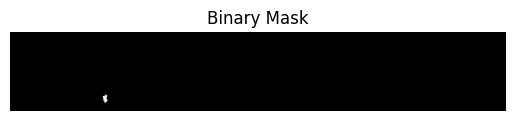

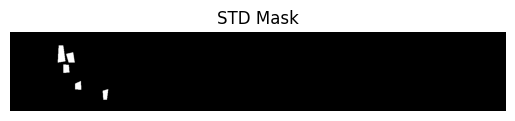

Epoch 1/3 - Validation: 100%|██████████| 68/68 [00:04<00:00, 16.43it/s]


Epoch 1/3 - Train Loss: 0.5154, Val Loss: 0.2221
✅ 保存最佳模型，验证损失: 0.2221


Epoch 2/3 - Validation:   0%|          | 0/68 [00:00<?, ?it/s]

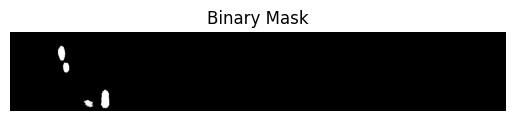

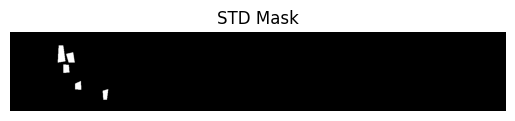

Epoch 2/3 - Validation: 100%|██████████| 68/68 [00:04<00:00, 16.52it/s]


Epoch 2/3 - Train Loss: 0.2026, Val Loss: 0.1581
✅ 保存最佳模型，验证损失: 0.1581


Epoch 3/3 - Validation:   0%|          | 0/68 [00:00<?, ?it/s]

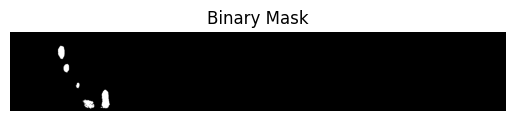

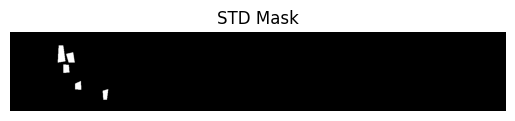

Epoch 3/3 - Validation: 100%|██████████| 68/68 [00:03<00:00, 17.94it/s]


Epoch 3/3 - Train Loss: 0.1256, Val Loss: 0.1053
✅ 保存最佳模型，验证损失: 0.1053


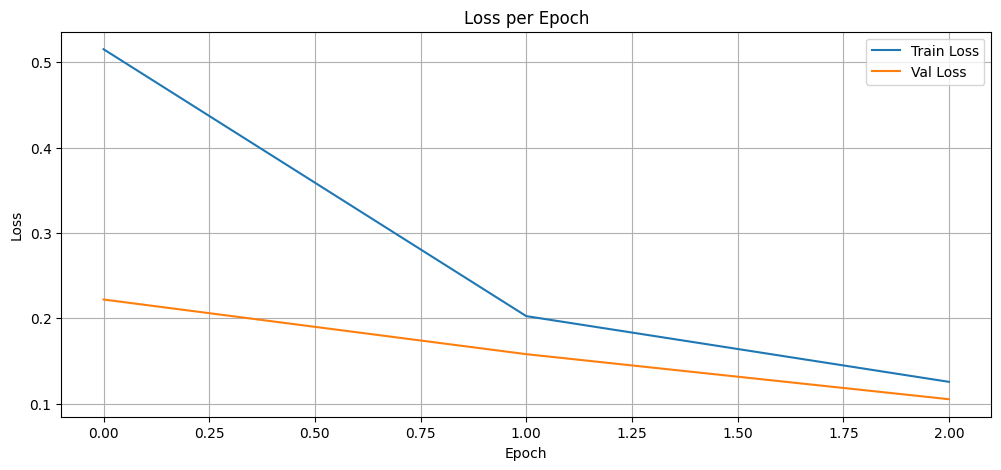

✅ 训练完成! 最佳验证损失: 0.1053
模型保存在: pretrained/1_unet_efficientnet-b3_best.pth
使用设备: cuda
创建模型: unet 使用编码器 efficientnet-b3


Epoch 1/3 - Validation:   0%|          | 0/19 [00:00<?, ?it/s]

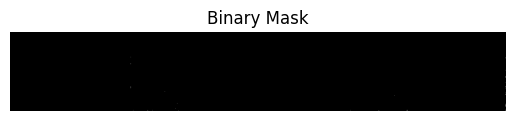

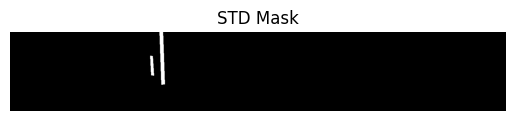

Epoch 1/3 - Validation: 100%|██████████| 19/19 [00:01<00:00, 17.62it/s]


Epoch 1/3 - Train Loss: 0.6279, Val Loss: 0.4480
✅ 保存最佳模型，验证损失: 0.4480


Epoch 2/3 - Validation:   0%|          | 0/19 [00:00<?, ?it/s]

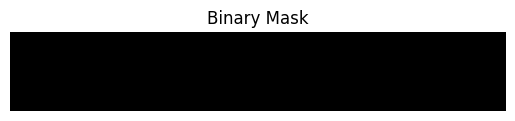

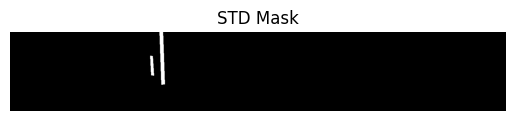

Epoch 2/3 - Validation: 100%|██████████| 19/19 [00:01<00:00, 17.92it/s]


Epoch 2/3 - Train Loss: 0.3579, Val Loss: 0.3329
✅ 保存最佳模型，验证损失: 0.3329


Epoch 3/3 - Validation:   0%|          | 0/19 [00:00<?, ?it/s]

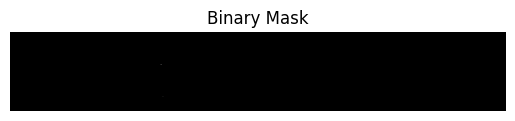

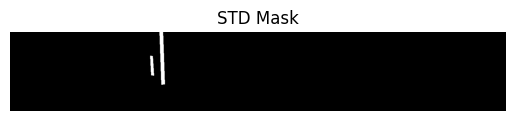

Epoch 3/3 - Validation: 100%|██████████| 19/19 [00:01<00:00, 17.95it/s]


Epoch 3/3 - Train Loss: 0.2568, Val Loss: 0.2793
✅ 保存最佳模型，验证损失: 0.2793


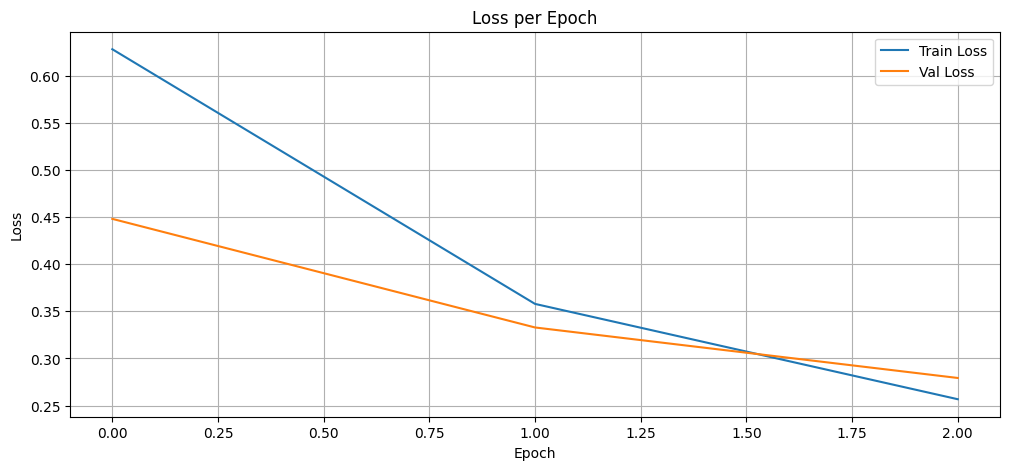

✅ 训练完成! 最佳验证损失: 0.2793
模型保存在: pretrained/2_unet_efficientnet-b3_best.pth
使用设备: cuda
创建模型: unet 使用编码器 efficientnet-b3


Epoch 1/3 - Validation:   0%|          | 0/387 [00:00<?, ?it/s]

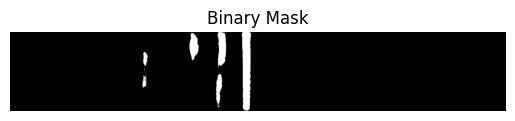

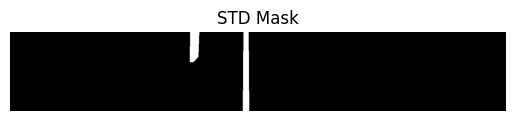

Epoch 1/3 - Validation: 100%|██████████| 387/387 [00:22<00:00, 17.40it/s]


Epoch 1/3 - Train Loss: 0.2630, Val Loss: 0.1155
✅ 保存最佳模型，验证损失: 0.1155


Epoch 2/3 - Validation:   0%|          | 0/387 [00:00<?, ?it/s]

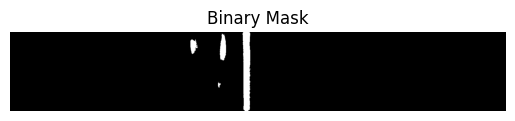

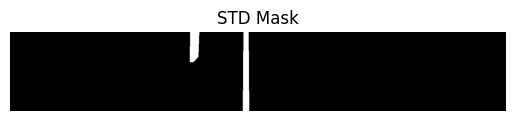

Epoch 2/3 - Validation: 100%|██████████| 387/387 [00:21<00:00, 17.61it/s]


Epoch 2/3 - Train Loss: 0.1182, Val Loss: 0.1048
✅ 保存最佳模型，验证损失: 0.1048


Epoch 3/3 - Validation:   0%|          | 0/387 [00:00<?, ?it/s]

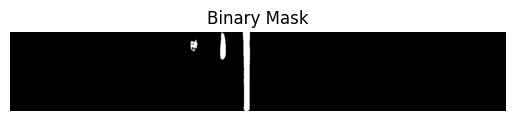

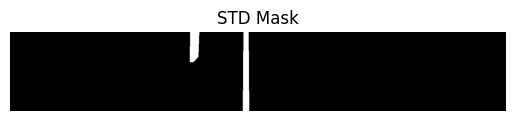

Epoch 3/3 - Validation: 100%|██████████| 387/387 [00:22<00:00, 17.40it/s]


Epoch 3/3 - Train Loss: 0.0961, Val Loss: 0.0964
✅ 保存最佳模型，验证损失: 0.0964


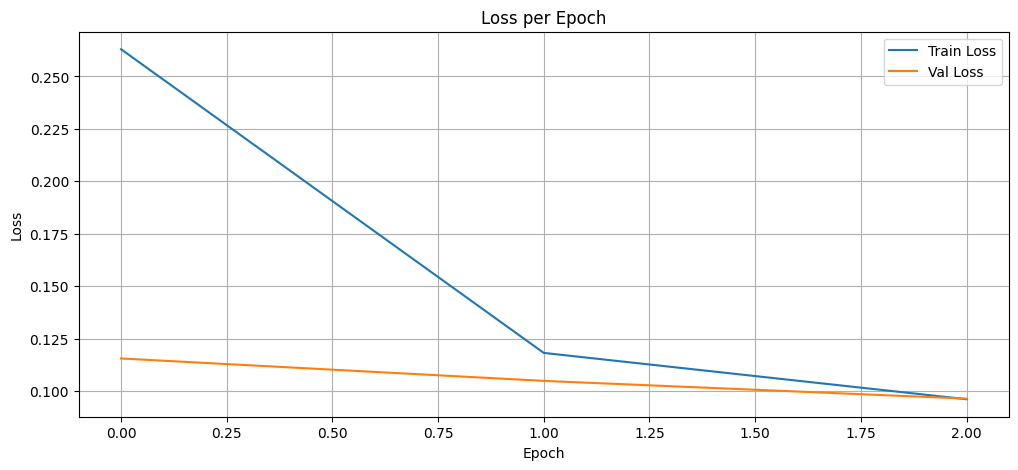

✅ 训练完成! 最佳验证损失: 0.0964
模型保存在: pretrained/3_unet_efficientnet-b3_best.pth
使用设备: cuda
创建模型: unet 使用编码器 efficientnet-b3


Epoch 1/3 - Validation:   0%|          | 0/61 [00:00<?, ?it/s]

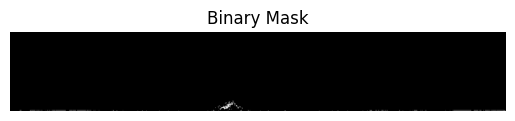

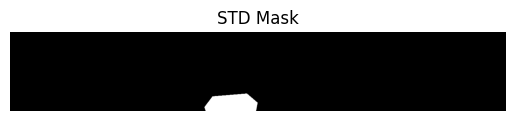

Epoch 1/3 - Validation: 100%|██████████| 61/61 [00:03<00:00, 16.54it/s]


Epoch 1/3 - Train Loss: 0.6114, Val Loss: 0.4739
✅ 保存最佳模型，验证损失: 0.4739


Epoch 2/3 - Validation:   0%|          | 0/61 [00:00<?, ?it/s]

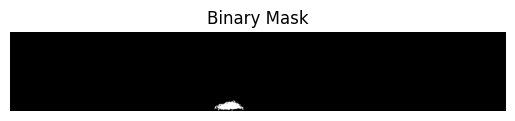

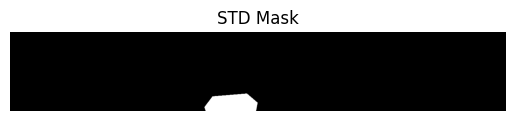

Epoch 2/3 - Validation: 100%|██████████| 61/61 [00:03<00:00, 16.27it/s]


Epoch 2/3 - Train Loss: 0.3160, Val Loss: 0.2457
✅ 保存最佳模型，验证损失: 0.2457


Epoch 3/3 - Validation:   0%|          | 0/61 [00:00<?, ?it/s]

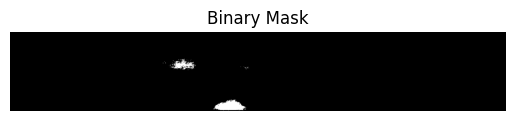

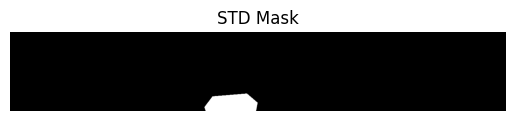

Epoch 3/3 - Validation: 100%|██████████| 61/61 [00:03<00:00, 17.24it/s]


Epoch 3/3 - Train Loss: 0.2161, Val Loss: 0.1894
✅ 保存最佳模型，验证损失: 0.1894


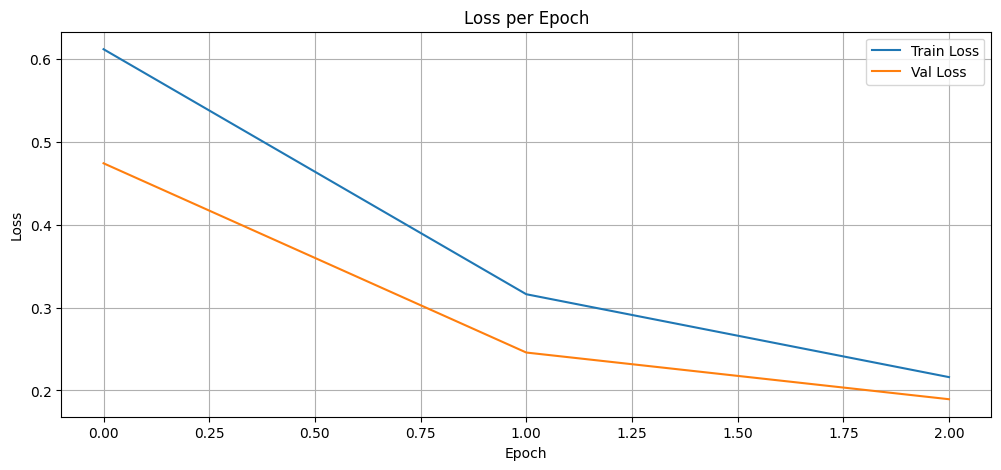

✅ 训练完成! 最佳验证损失: 0.1894
模型保存在: pretrained/4_unet_efficientnet-b3_best.pth


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from model import SMPModel, get_smp_model
from dataset import SteelDataset
import torchvision.transforms as T
import pandas as pd
from tqdm import tqdm
import os
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

transform = T.Compose([
    T.ToTensor(),
])

import numpy as np
def rle2mask(rle, shape=(1600, 256)):
    if pd.isnull(rle):
        return np.zeros(shape, dtype=np.uint8).T
    rle = list(map(int, rle.strip().split()))
    starts, lengths = rle[0::2], rle[1::2]
    starts = np.array(starts) - 1
    ends = starts + lengths
    mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for s, e in zip(starts, ends):
        mask[s:e] = 1
    return mask.reshape(shape).T

def mask2rle(mask):
    """
    将掩码转换为 RLE (Run Length Encoding) 格式
    """
    pixels = mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    starts = runs[0::2]
    ends = runs[1::2]
    lengths = ends - starts
    rle = ' '.join(str(s) + ' ' + str(l) for s, l in zip(starts, lengths))
    return rle

for cls in range(1,5):
    dataset = SteelDataset("../data/train_images",
                           "../data/train.csv", cls, transform=transform)

    # 划分训练/验证集
    train_len = int(0.7 * len(dataset))
    val_len = len(dataset) - train_len
    train_set, val_set = random_split(dataset, [train_len, val_len])
    train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=4)

    # 设备配置
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用设备: {device}")

    # 选择模型类型和编码器
    model_type = "unet"  # 可选: 'unet', 'fpn', 'pspnet', 'deeplabv3', 'deeplabv3plus'
    encoder_name = "efficientnet-b3"  # 可选: 'resnet34', 'efficientnet-b0', 'mobilenet_v2' 等
    classes = 1  # 一种钢铁缺陷类别（是/不是）

    # 创建模型
    model = get_smp_model(model_type, encoder_name, classes).to(device)
    print(f"创建模型: {model_type} 使用编码器 {encoder_name}")

    # 优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # 使用 SMP 的损失函数
    # DiceLoss 适合分割任务
    dice_loss = smp.losses.DiceLoss(mode='binary')
    # 也可以使用组合损失函数
    bce_loss = smp.losses.SoftBCEWithLogitsLoss()
    focal_loss = smp.losses.FocalLoss(mode='binary', gamma=2.0, alpha=0.75)
    # loss_fn = lambda pred, target: dice_loss(pred, target) + focal_loss(pred, target)
    # loss_fn = lambda pred, target: dice_loss(pred, target) + bce_loss(pred, target)
    loss_fn = lambda pred, target: focal_loss(pred, target) + bce_loss(pred, target)

    # 训练参数
    num_epochs = 3
    early_stop_patience = 5
    early_stop_count = 0
    best_val_loss = float('inf')

    # 创建保存检查点的文件夹
    os.makedirs("pretrained", exist_ok=True)

    # 训练循环
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()

        train_loss = 0.0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")

        for imgs, masks in train_bar:

            imgs, masks = imgs.to(device), masks.to(device)

            # 前向传播
            outputs = model(imgs)
            loss = loss_fn(outputs, masks)

            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 更新进度条
            train_loss += loss.item()
            train_bar.set_postfix(loss=f"{loss.item():.4f}")

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # 验证阶段
        model.eval()
        val_loss = 0.0
        First = True
        with torch.no_grad():
            for imgs, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(imgs)
                loss = loss_fn(outputs, masks)
                val_loss += loss.item()
                if First == True:
                    # 假设 mask 是一个 numpy 数组，shape: (H, W)，值为 0 或 1
                    plt.imshow(outputs[0][0].cpu().sigmoid().numpy() > 0.5, cmap='gray')
                    plt.title("Binary Mask")
                    plt.axis('off')
                    plt.show()
                    plt.imshow(masks[0][0].cpu().numpy(), cmap='gray')
                    plt.title("STD Mask")
                    plt.axis('off')
                    plt.show()
                    First = False

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # 打印训练和验证损失
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # 保存最佳模型
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), f"pretrained/{cls}_{model_type}_{encoder_name}_best.pth")
            print(f"✅ 保存最佳模型，验证损失: {best_val_loss:.4f}")
            early_stop_count = 0
        else:
            early_stop_count += 1

        # 保存最新的检查点
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
        }, f"pretrained/{cls}_{model_type}_{encoder_name}_latest.pth")

        if early_stop_count >= early_stop_patience:
            print(f"早停触发，验证损失在 {early_stop_patience} 个周期内没有改善。")
            break

    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"✅ 训练完成! 最佳验证损失: {best_val_loss:.4f}")
    print(f"模型保存在: pretrained/{cls}_{model_type}_{encoder_name}_best.pth")